### Merge annotated timelapse into one dataset
Last notebook to create training data. After setting a data path and a set of
filenames, this notebook will load the unified timelapses (and potentially
masks) from 01_process_training_timelapses.ipynb and labels created by
02_label_training_timelapses.ipynb. The merged timelapse, merged masks and
merged labels are saved in the end.



In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tifffile import imsave

import napari
plt.style.use('dark_background')

In [2]:
def load_all_training_data(tlapse_names):
    """
    From a set of basenames, load the three elements of training data: the
    timelapse itself, a matching segmentation mask (may be None), and the 
    matching growth cone labels. 
    
    Arguments
    ---------
        tlapse_names: [str, str, ...]
            The basenames to load the training data pieces.
    Returns
    -------
        signals, masks, lbls: np.array of shape [txHxW] of dtype uint16
                              np.array of shape [HxW] of dtype bool
                              pd.DataFrame of shape [t, nIDs*2]
            timelapse, segmentation mask, and growth cone labels. All have the 
            same length as the passed `tlapse_names`.
    """
    signals, masks, lbls = [], [], []
    for i in range(len(tlapse_names)):
        basename = tlapse_names[i]
        signals.append(load_timelapse(basename, postfix=''))
        masks.append(load_timelapse_mask(basename, postfix=''))
        lbls.append(merge_axonID_files(basename))
    return signals, masks, lbls

In [3]:
def merge_all_training_data(signals, masks, lbls):
    """
    Merge together the training data from a list of labelled timelapses.
    
    Arguments
    ---------
        signals: [np.array of shape [txHxW] of dtype uint16, ...]
            The list of timelapses. 
        masks: [np.array of shape [HxW] of dtype bool, ...]
            The list of masks. If masks are None use a np.ones mask (keep all).
        lbls: [pd.DataFrame of shape [t, nIDs*2], ...]
            The list of labels. Labels are adjusted to match the merged time
            series and avoid axon ID duplicates.
                              
    Returns
    -------
        final_signals, final_masks, final_lbls: np.array of shape [TxHxW], uint16
                                                np.array of shape [TxHxW], bool
                                                pd.DataFrame of shape [T, nIDs*2]
            Merged timelapse, segmentation mask, and growth cone labels. The
            final temporal dimension T follows from the sum of [t, ...] in the
            timelapses.
    """
    last_t, last_ID = 0, 0
    final_lbls_adjusted, final_masks = [], []
    for i in range(len(signals)):
        ntimepoints = signals[i].shape[0]
        lbl = lbls[i].copy()
        # fix timepoints for concatenated data
        lbl.index += last_t
        # fix the axon names (count up)
        cols = [(f'Axon_{int(ax[-3:])+last_ID:0>3}', anch) for ax, anch in lbl.columns]
        lbl.columns = pd.MultiIndex.from_tuples(cols)
        
        # have the mask match the frames temporal dim
        mask = np.ones(signals[i].shape[1:]) if masks[i] is None else masks[i]
        final_masks.extend([mask for _ in range(ntimepoints)])
        
        last_t += ntimepoints
        last_ID += len(lbl.columns.unique(0))
        final_lbls_adjusted.append(lbl)
    # merge everything
    final_signal = np.concatenate(signals, axis=0)
    final_mask = np.stack(final_masks, axis=0)
    final_lbls = pd.concat(final_lbls_adjusted, axis=1)
    return final_signal, final_mask, final_lbls

In [4]:
def validate_training_data(final_signal, final_mask, final_lbls, viewer, 
                           skip_lbls=False):
    """
    Load the timelapse, segmentation mask and labels into the GUI to confirm
    correct merging.
    
    Arguments
    ---------
        tlapse_names: [str, str, ...]
            The basenames to load the training data pieces.
    Returns
    -------
        final_signal: np.array of shape [TxHxW] of dtype uint16 
            The merged timelapse to load.
        
        final_mask: np.array of shape [TxHxW] of dtype bool
            The merged segmentation mask to load.
        
        final_lbls: pd.DataFrame of shape [T, nIDs*2]
            The merged growth cone labels to load.

        viewer: napari.ImageViewer
            The viewer instance used to load the training data.

        skip_lbls: bool
            Wheather to load the labels or not. Can e slow. Defaults to False.
                              
    """
    viewer.add_image(final_signal, contrast_limits=(0, 2**10))
    viewer.add_image(final_mask)
    if not skip_lbls:
        axonIDs2gui(final_lbls, viewer)

In [6]:
def save_all_training_data(final_signal, final_mask, final_lbls):
           """
    Save the training data consisting of timelapse, segmentation mask and labels
    to matching files. Files are saved into the data_path directory.
    
    Arguments
    ---------
        final_signal: np.array of shape [TxHxW] of dtype uint16 
            The merged timelapse to save.
        
        final_mask: np.array of shape [TxHxW] of dtype bool
            The merged segmentation mask to save.
        
        final_lbls: pd.DataFrame of shape [T, nIDs*2]
            The merged growth cone labels to save.
                              
    """
    print(f'Saving timelapse, masks and labels at {data_path}')
    imsave(f'{data_path}/training_timelapse.tif', final_signal, 
           photometric='minisblack', compression='deflate', bigtiff=True)
    np.save(f'{data_path}/training_mask.npy', final_mask)
    final_lbls.to_csv(f'{data_path}/training_labels.csv')

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 18)

### Run below to merge labelled training data

In [7]:
# get the load_timelapse and load_mask function
%run 01_process_training_timelapses.ipynb
# get the load_axonIDs function
%run 02_label_training_timelapses.ipynb

Loaded functions `load_timelapse`, `load_mask` successfully.


SystemExit: Function `load_axonIDs` `timelapse2gui` loaded successfully.

/home/loaloa/programs/anaconda3/envs/napari-env-2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


SystemExit: Function `load_axonIDs` `timelapse2gui` loaded successfully.

In [8]:
# create the viewer for later
viewer = napari.Viewer()

In [9]:
# set the dataset names
data_path = '/run/media/loaloa/lbbSSD/training_data/'
tlapse_names = ['D00_G001', 'D04_G004', 'D19_G035']



=== `D00_G001` tif loaded ===
TxHxW: 37x2080x5764
dtype: uint16
min:0, max:4095
Frame wise min: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


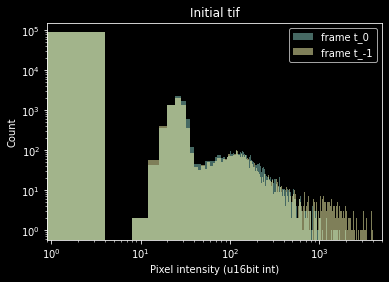

Mask file not found: /run/media/loaloa/lbbSSD/training_data//D00_G001.npy
Loading labels for D00_G001. Found the following files: ['/run/media/loaloa/lbbSSD/training_data//all_labels_csvs/D00_G001_labels_IDs_000-099.csv']
   Axon_000 Axon_001 Axon_002 Axon_003 Axon_004 Axon_005 Axon_006 Axon_007  \
   anchor_y anchor_y anchor_y anchor_y anchor_y anchor_y anchor_y anchor_y   
0    1180.0   1284.0     1159     1168   1168.0      NaN      NaN      NaN   
1    1205.0   1226.0     1159     1174   1173.0      NaN      NaN      NaN   
2    1256.0   1309.0     1164     1212   1212.0      NaN      NaN      NaN   
3    1325.0   1379.0     1159     1249   1273.0      NaN      NaN      NaN   
4    1420.0   1469.0     1162     1294   1282.0      NaN      NaN      NaN   
5    1476.0   1521.0     1164     1343   1343.0      NaN   1890.0      NaN   
6    1561.0   1588.0     1169     1395   1398.0      NaN   1886.0      NaN   
7    1645.0   1640.0     1172     1442   1450.0      NaN   1900.0      NaN  

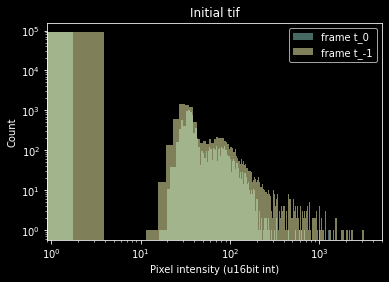

=== `D04_G004` npy mask loaded ===
HxW: 2080x5764

Loading labels for D04_G004. Found the following files: ['/run/media/loaloa/lbbSSD/training_data//all_labels_csvs/D04_G004_labels_IDs_000-066.csv']
   Axon_000          Axon_001          Axon_002          Axon_003           \
   anchor_y anchor_x anchor_y anchor_x anchor_y anchor_x anchor_y anchor_x   
0    1651.0   1965.0      NaN      NaN      NaN      NaN      NaN      NaN   
1    1633.0   1954.0      NaN      NaN      NaN      NaN      NaN      NaN   
2    1605.0   1962.0      NaN      NaN      NaN      NaN      NaN      NaN   
3    1581.0   1978.0      NaN      NaN      NaN      NaN   1977.0   1620.0   
4    1574.0   1978.0      NaN      NaN      NaN      NaN   1969.0   1622.0   
..      ...      ...      ...      ...      ...      ...      ...      ...   
76   1309.0   2743.0      NaN      NaN   1325.0   2562.0   1449.0   1728.0   
77   1306.0   2744.0      NaN      NaN   1323.0   2558.0   1455.0   1730.0   
78   1310.0   2747.0 

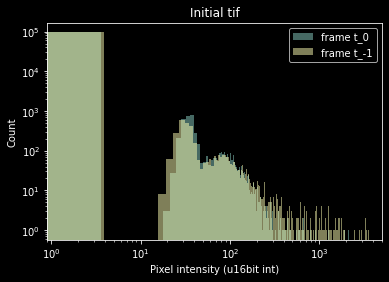

=== `D19_G035` npy mask loaded ===
HxW: 2080x5764

Loading labels for D19_G035. Found the following files: ['/run/media/loaloa/lbbSSD/training_data//all_labels_csvs/D19_G035_labels_IDs_000-132.csv']
      Axon_000          Axon_001          Axon_002          Axon_003           \
      anchor_y anchor_x anchor_y anchor_x anchor_y anchor_x anchor_y anchor_x   
0.0        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1.0        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2.0        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3.0        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4.0        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...        ...      ...      ...      ...      ...      ...      ...      ...   
205.0      NaN      NaN   1102.0    955.0      NaN      NaN      NaN      NaN   
206.0      NaN      NaN   1105.0    955.0      NaN      NaN      NaN    

In [10]:
# Load the timelapses and merge them
signals, masks, lbls = load_all_training_data(tlapse_names)
all_signals, all_masks, all_lbls = merge_all_training_data(signals, masks, lbls)

In [11]:
# load whole training data into viewer to ensure corretness before final save
validate_training_data(all_signals, all_masks, all_lbls, viewer, skip_lbls=True)

In [18]:
# finally save the training data
save_all_training_data(all_signals, all_masks, all_lbls)

Saving timelapse, masks and labels at /run/media/loaloa/lbbSSD/training_data/
